In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [80]:
df = pd.read_csv(r'/kaggle/input/southeast-2/southeast (2).csv', delimiter=',')

pressure =  df['pressure'].fillna(df['pressure'].mean())
my_dict = {key: [val] for key, val in zip(df['Unnamed: 0'].tolist(), pressure)}

new_df = pd.DataFrame({'meas': ['pressure']})

new_df = pd.concat([new_df, pd.DataFrame(my_dict)], axis=1)
new_df

,meas,2023_12_1,2024_1_1,2024_2_1,2024_3_1,2024_4_1,2024_5_1,2019_6_1,2024_7_1,2024_8_1,...,2025_5_1,2025_6_1,2025_7_1,2025_8_1,2025_9_1,2025_10_1,2025_11_1,2025_12_1,2026_1_1,2026_2_1
0,pressure,100910.324985,100764.491311,101056.158659,100910.324985,100764.491311,101056.158659,100910.324985,100764.491311,101056.158659,...,101056.158659,100910.324985,100764.491311,101056.158659,100910.324985,100764.491311,101056.158659,100910.324985,100764.491311,101056.158659


In [81]:
new_df.shape

(1, 28)

In [5]:
!pip install catboost

In [82]:
!nvidia-smi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Sat Apr 27 13:28:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

NameError: name 'torch' is not defined

In [83]:
pressure_values = new_df[new_df['meas'] == 'pressure'].iloc[0, 1:].values
df = pd.DataFrame(pressure_values)
df

,0
0,100910.324985
1,100764.491311
2,101056.158659
3,100910.324985
4,100764.491311
5,101056.158659
6,100910.324985
7,100764.491311
8,101056.158659
9,100910.324985


In [84]:
df = df.rename(columns={df.columns[0]:'preassure'})

<Axes: >

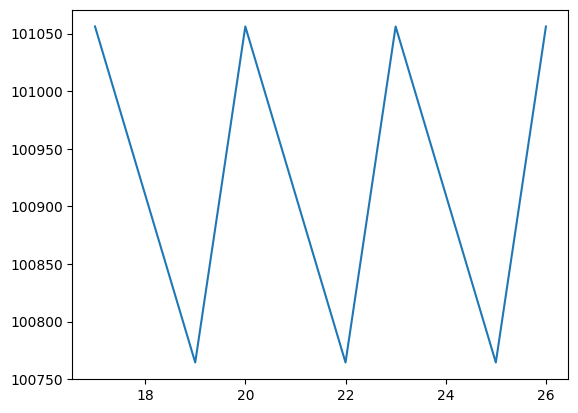

In [85]:
df.iloc[:,0][-10:].plot()

In [86]:
df['date'] = new_df.columns[1:]
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y_%m_%d'))
df['date'] = df['date'].apply(lambda x: x.strftime("%Y-%m-%d"))
 
df1 = df.set_index('date')
 

In [87]:
 
df1.head()


,preassure
date,
2023-12-01,100910.324985
2024-01-01,100764.491311
2024-02-01,101056.158659
2024-03-01,100910.324985
2024-04-01,100764.491311


In [191]:
# df.preassure = df.preassure[::-1].reset_index(drop=True)

In [192]:
# df['date'] = pd.to_datetime(df['date'])
# df.date = df['date'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
# df

,preassure
date,
2024-04-26 00:03:20,NaN
2024-04-26 00:08:20,NaN
2024-04-26 00:13:20,NaN
2024-04-26 00:18:21,NaN
2024-04-26 00:23:22,NaN
...,...
2024-04-26 23:37:24,NaN
2024-04-26 23:42:25,NaN
2024-04-26 23:47:25,NaN


In [88]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 2023-12-01 to 2026-02-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   preassure  27 non-null     object
dtypes: object(1)
memory usage: 432.0+ bytes


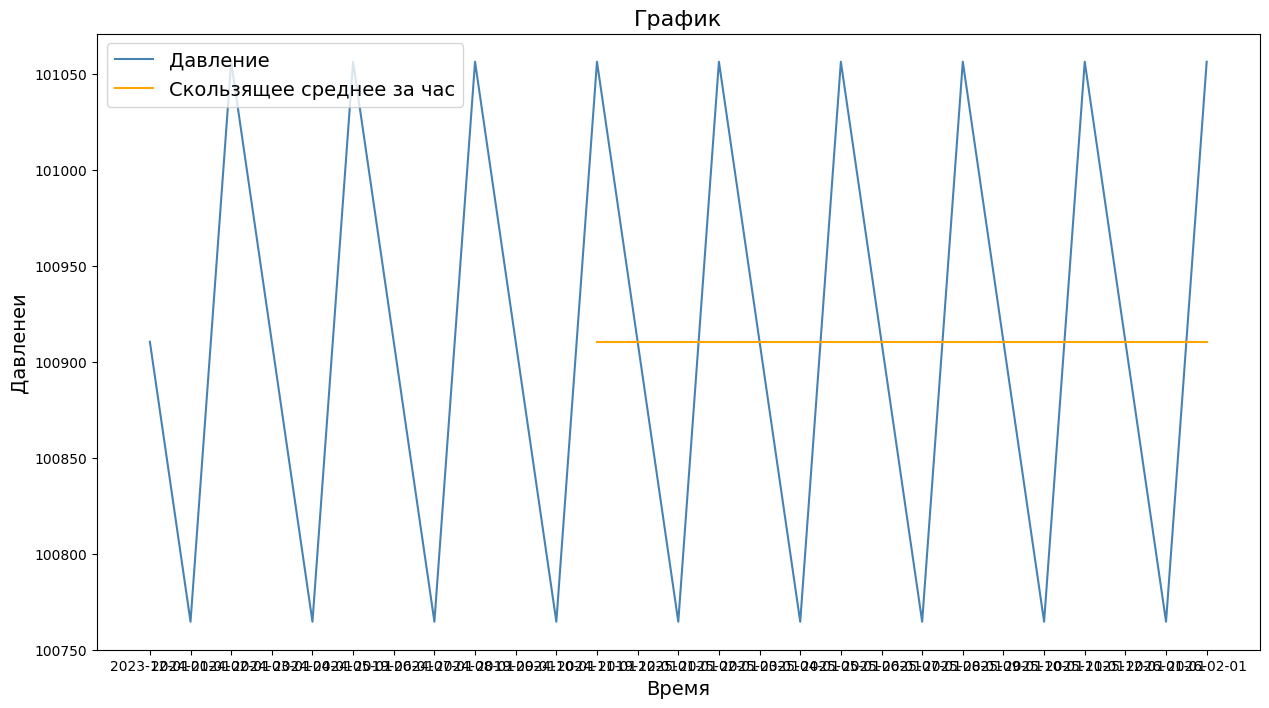

In [89]:
plt.figure(figsize = (15,8))

plt.plot(df1['preassure'], label = 'Давление', color = 'steelblue')
plt.plot(df1['preassure'].rolling(window = 12).mean(), label = 'Скользящее среднее за час', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)
 
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Давленеи', fontsize = 14)
plt.title('График', fontsize = 16)
 
plt.show()

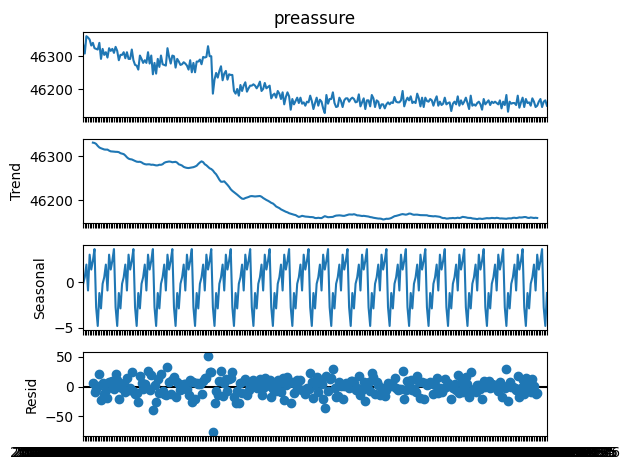

In [36]:
seasonal_decompose(df1.preassure, model = 'additive', period = 12).plot()
plt.show()

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [90]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(df1['preassure'])

ADF Statistic: -54942954.28449596
p-value: 0.0
Stationary


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:957: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


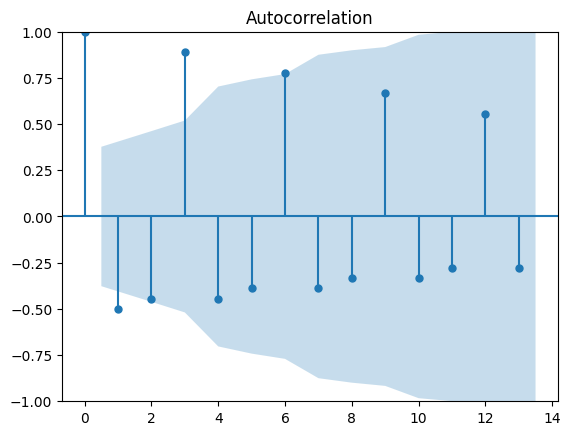

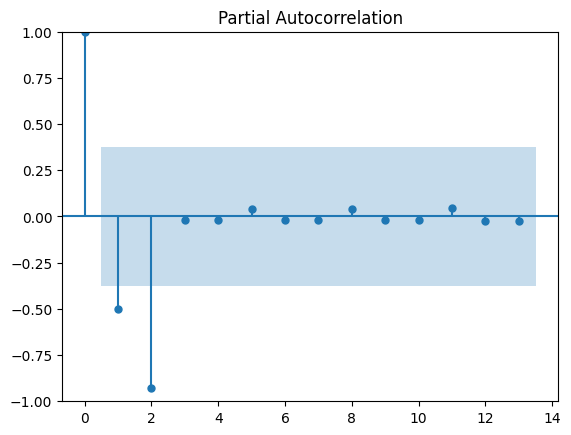

In [91]:
plot_acf(df1.preassure)
plot_pacf(df1.preassure)
plt.show()

In [93]:

p, d, q = 3, 1, 3
P, D, Q, s = 1, 1, 1, 12  # Assuming monthly seasonality
 
df1['preassure'] = pd.to_numeric(df1['preassure'], errors='coerce')

# Fit SARIMAX model
model = SARIMAX(df1['preassure'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsm

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.50061D+00    |proj g|=  1.78774D+05
  ys=-4.236E+01  -gs= 5.257E-01 BFGS update SKIPPED
  ys=-7.736E-06  -gs= 3.605E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      4     79      2     2     0   2.683D+05  -5.732D+00
  F =  -5.7317466815238225     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


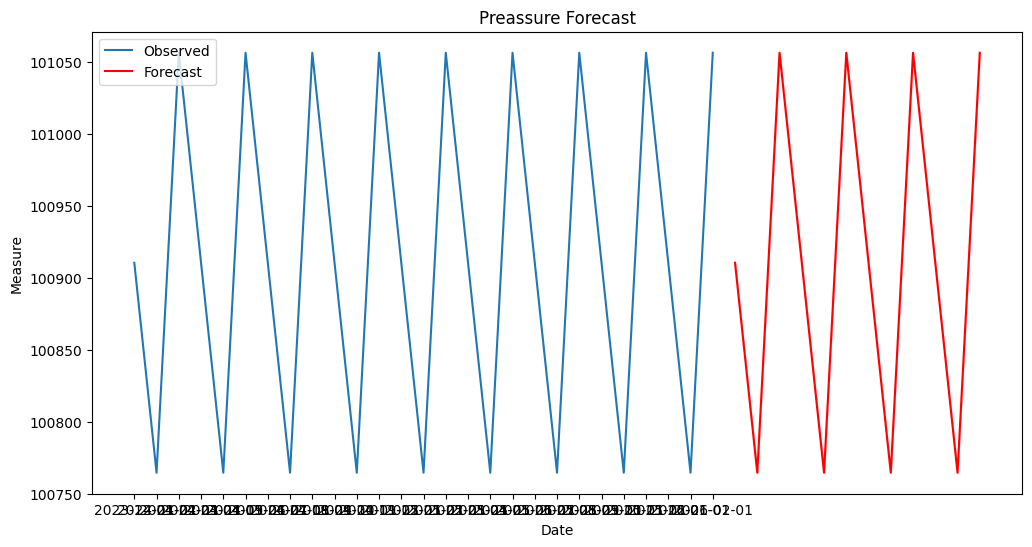

In [94]:
forecast_periods = 12  # Forecast the next 60 minutes
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df1.preassure, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Preassure Forecast")
plt.xlabel("Date")
plt.ylabel("Measure")
plt.legend()
plt.show()

In [95]:
 
observed = df1[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 1.697723443309466e-11
MSE: 3.1763735522036263e-22


In [96]:
train = df[:round(df.shape[0]*0.75)]
test = df[round(df.shape[0]*0.75):]

In [97]:
marks = []


In [99]:
seasonal_periods_range = [7,30]
trend_range = ['add', 'mul', None]
seasonal_range = ['add', 'mul', None]
for p in seasonal_periods_range:
    for t in trend_range:
        for s in seasonal_range:
          fitted_model = ExponentialSmoothing(train['preassure'],trend=t,seasonal=s,seasonal_periods=p).fit()
          test_predictions = fitted_model.forecast(test.shape[0]).rename('HW Test Forecast')
          print(t,s,p,mape(test.preassure, test_predictions))
          marks.append(mape(test.preassure, test_predictions))

add add 7 0.0005621380990959515
add mul 7 0.00024558616022733775
add None 7 0.000564822133531221


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


mul add 7 0.00041377471646937564


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


mul mul 7 0.00026409789020022303
mul None 7 5.345999242209099
None add 7 0.00024276054599249147
None mul 7 0.00024708547903882464
None None 7 0.00022708785165514647
add add 30 0.0005456704008630202
add mul 30 0.0002844855888468917
add None 30 0.000564822133531221


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


mul add 30 0.002225568194998209
mul mul 30 0.00137299302163881
mul None 30 5.345999242209099
None add 30 0.0002913899502073297
None mul 30 0.0002621740517992847
None None 30 0.00022708785165514647


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/tmp/ipykernel_34/3692670701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1.loc[len(train)] = [test.preassure[len(train)], str((datetime.strptime(train.iloc[len(train)-1].date, "%Y-%m-%d %H:%M:%S") + timedelta(days=1)).strftime("%Y-%m-%d %H:%M:%S"))]


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

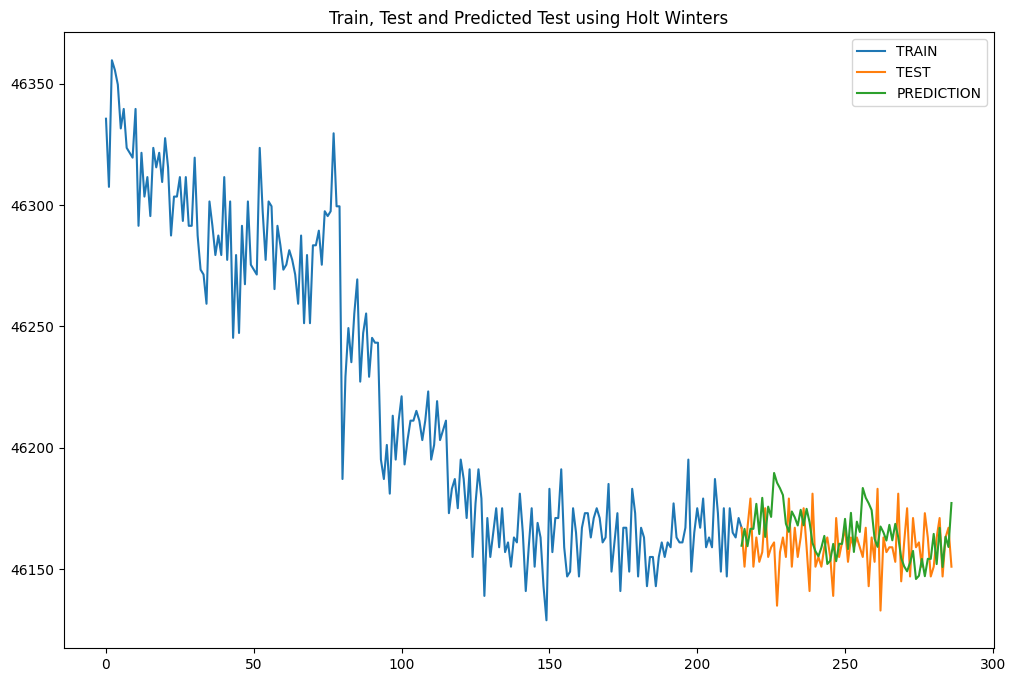

In [100]:

fitted_model = ExponentialSmoothing(train['preassure'],trend='add',seasonal='mul',seasonal_periods=30).fit()
test_predictions = fitted_model.forecast(test.shape[0]).rename('preassure')
train1 = train
train1.loc[len(train)] = [test.preassure[len(train)], str((datetime.strptime(train.iloc[len(train)-1].date, "%Y-%m-%d %H:%M:%S") + timedelta(days=1)).strftime("%Y-%m-%d %H:%M:%S"))]
train1['preassure'].plot(legend=True,label='TRAIN')
test['preassure'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [101]:
train = df[:round(df.shape[0]*0.75)]
test = df[round(df.shape[0]*0.75):]
     

marks = []
     

seasonal_periods_range = [7,30]
trend_range = ['add', 'mul', None]
seasonal_range = ['add', 'mul', None]
for p in seasonal_periods_range:
  for t in trend_range:
    for s in seasonal_range:
      fitted_model = ExponentialSmoothing(train['preassure'],trend=t,seasonal=s,seasonal_periods=p).fit()
      test_predictions = fitted_model.forecast(test.shape[0]).rename('HW Test Forecast')
      print(t,s,p,mape(test.preassure, test_predictions))
      marks.append(mape(test.preassure, test_predictions))

add add 7 0.0005621380990959515
add mul 7 0.00024558616022733775
add None 7 0.000564822133531221


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


mul add 7 0.00041377471646937564


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


mul mul 7 0.00026409789020022303
mul None 7 5.345999242209099
None add 7 0.00024276054599249147
None mul 7 0.00024708547903882464
None None 7 0.00022708785165514647
add add 30 0.0005456704008630202
add mul 30 0.0002844855888468917
add None 30 0.000564822133531221


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


mul add 30 0.002225568194998209
mul mul 30 0.00137299302163881
mul None 30 5.345999242209099
None add 30 0.0002913899502073297
None mul 30 0.0002621740517992847
None None 30 0.00022708785165514647


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [102]:
def clear_df(df):
    df = df.rename(columns=lambda x: x.lower())
    date_range = pd.date_range(start=df.date[0], end=df.date[df.date.size-1], freq='D')
    df_full_dates = pd.DataFrame(date_range, columns=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df = pd.merge(df_full_dates, df, how='left', on='date')
    return df

In [111]:

def make_df(df:pd.DataFrame, lookback:int = 7):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df.date.apply(lambda x: x.year)
    df['month'] = df.date.apply(lambda x: x.month)
    df['day'] = df.date.apply(lambda x: x.day)
    df['hour'] = df.date.apply(lambda x: x.hour)
    df['minute'] = df.date.apply(lambda x: x.minute)
    df['second'] = df.date.apply(lambda x: x.second)
    print(df)
    df = df.drop(columns = ['date'])
    for i in range(1,lookback+1):
        df['shift'+str(i)] = df. preassure.shift(i)
    df = df[lookback:]
    return df.reset_index(drop=True)

In [112]:
df_cb = make_df(df,7)

     preassure                date  year  month  day  hour  minute  second
0     46335.53 2024-04-26 00:03:20  2024      4   26     0       3      20
1     46307.47 2024-04-26 00:08:20  2024      4   26     0       8      20
2     46359.59 2024-04-26 00:13:20  2024      4   26     0      13      20
3     46355.59 2024-04-26 00:18:21  2024      4   26     0      18      21
4     46349.59 2024-04-26 00:23:22  2024      4   26     0      23      22
..         ...                 ...   ...    ...  ...   ...     ...     ...
282   46171.13 2024-04-26 23:37:24  2024      4   26    23      37      24
283   46147.06 2024-04-26 23:42:25  2024      4   26    23      42      25
284   46163.13 2024-04-26 23:47:25  2024      4   26    23      47      25
285   46167.13 2024-04-26 23:52:25  2024      4   26    23      52      25
286   46151.09 2024-04-26 23:57:26  2024      4   26    23      57      26

[287 rows x 8 columns]


In [114]:
cb = CatBoostRegressor()
     

y = df_cb['preassure']
X = df_cb.drop(columns=['preassure'])
     

r = 0.75
ind = round(r*len(X))
X_train = X[:ind]
X_test = X[ind:]
y_train = y[:ind]
y_test = y[ind:]
     

cb.fit(X_train,y_train)

Learning rate set to 0.031996
0:	learn: 58.3157097	total: 60.5ms	remaining: 1m
1:	learn: 56.9346073	total: 61.1ms	remaining: 30.5s
2:	learn: 55.5700328	total: 61.7ms	remaining: 20.5s
3:	learn: 54.1234208	total: 62.2ms	remaining: 15.5s
4:	learn: 52.7794994	total: 62.8ms	remaining: 12.5s
5:	learn: 51.4657777	total: 63.3ms	remaining: 10.5s
6:	learn: 50.2720715	total: 63.8ms	remaining: 9.05s
7:	learn: 49.0534212	total: 64.3ms	remaining: 7.98s
8:	learn: 47.9872947	total: 64.8ms	remaining: 7.14s
9:	learn: 46.8555763	total: 65.4ms	remaining: 6.47s
10:	learn: 45.8558247	total: 65.9ms	remaining: 5.92s
11:	learn: 44.8038744	total: 66.4ms	remaining: 5.47s
12:	learn: 43.8104306	total: 67ms	remaining: 5.08s
13:	learn: 42.7578484	total: 67.5ms	remaining: 4.76s
14:	learn: 41.8121555	total: 68.1ms	remaining: 4.47s
15:	learn: 40.8049886	total: 68.6ms	remaining: 4.22s
16:	learn: 39.9065337	total: 69.2ms	remaining: 4s
17:	learn: 39.0096320	total: 69.7ms	remaining: 3.8s
18:	learn: 38.0863824	total: 70.2ms

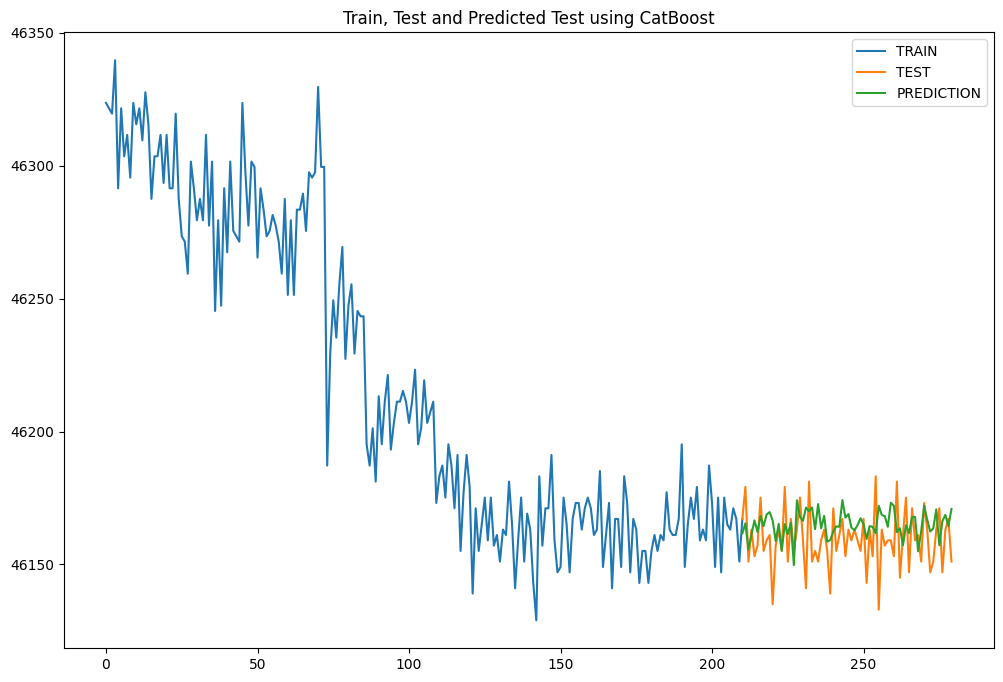

In [116]:
preds = cb.predict(X_test)
     

mape(y_test,preds)
     
# 0.6646500559797219

preds = pd.Series(preds)
preds.index = y_test.index
     

y_train.loc[len(y_train)] = y_test[len(y_train)]
y_train.plot(legend=True,label='TRAIN')
y_test.plot(legend=True,label='TEST',figsize=(12,8))
preds.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using CatBoost');